# Introduction:
***
This tutorial will introduce a few basic methods for processing financial data, with a focus on individual stock growth. Financial data is an area where many individuals and corporations take interest in with the hope of predicting market movement and direction in order to make informed trade decisions for profit. As with many data science topics, the goal would be to utilize the data and interpret in a meaningful way to identify and/or predict trends.     
  
  
# Tutorial Content: 
***
Due to my extremely limited knowledge of the financial field, this tutorial will have a focus on acquiring and visualizing the data, with a bit of data analysis and machine learning to illustrate some concepts. In this tutorial, a few of the main python libraries we will be utilizing are [Pandas](http://pandas.pydata.org/pandas-docs/version/0.19.2/), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), and [pyplot](https://matplotlib.org/).  
  
We will be utilizing data scraped from Bloomberg's stocks section: https://www.bloomberg.com/markets/stocks, as well as historical stock data from Google finance: https://www.google.com/finance. While the data from Bloomberg only displays a fairly limited number of stocks representative of each region, the methods from this tutorial can be extended for usage on other websites with moderate tweaking.  
  
In this tutorial, we will cover the basic concepts of the data science pipeline, including but not limited to the following subjects:  
* Data Curation, Parsing, and Management
* Exploratory Data Analysis
* Hypothesis Testing
* Machine Learning

# Setup:
***
Before we get started with anything else, we need to import a few python libraries that will be critical to this tutorial. Below is the code provided to set up the notebook. Don't worry too much about the imports for now since they will be explained as they come up in this tutorial.

In [1]:
import html5lib, re, requests
from scipy import stats
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from sklearn import datasets

# Optimize notebook width, row, and columns for for visual clarity
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 1000)

# Data Curation, Parsing, and Management
***
Before we can even begin doing any sort of analysis, we must first acquire data to perform analysis on. That brings us to the first step within the data science pipeline: data curation. Data curation is very broad term that can refer to the management of data anywhere from the creation of it and its storage, to its archival and deletion. Clearly this seems quite expansive but we can take it in this context to essentially mean gathering data and storing it in a suitable medium.  
  
For this tutorial, we will be utilizing the 'requests' library to perform HTTP get requests on websites for web scraping (to retrieve its HTML). To begin, we want to scrape the stock data from Bloomberg's Americas, Europe, Africa, Middle East, and Asian Pacific markets. We can retrieve the website using the following code:

In [2]:
# Use requests to get a connection to the URL
temp = requests.get('https://www.bloomberg.com/markets/stocks/world-indexes/americas')
temp2 = requests.get('https://www.bloomberg.com/markets/stocks/world-indexes/europe-africa-middle-east')
temp3 = requests.get('https://www.bloomberg.com/markets/stocks/world-indexes/asia-pacific')

# The above line of code will give us a connection to the website but we can't quite do anything with that so what 
# we'll want to do is utilize the 'BeautifulSoup' library to parse the data into lxml:
root = BeautifulSoup(temp.content,'lxml')
root2 = BeautifulSoup(temp2.content,'lxml')
root3 = BeautifulSoup(temp3.content,'lxml')

Now that we have the website, we'll want to look through the HTML to find out where the relevant data of the website will be contained. By analyzing Bloomberg's HTML, we can see that each row of stock data is contained within a '<tr>' tag with the class of 'data-table-row.' Since we know all of this, we can utilize 'BeautifulSoup' findAll() function in order to parse through the data and return all of the stock data rows. Now that we have this data we'll want to store it in a 'Pandas' dataframe since it provides an efficient data structure that possesses high-performance and allows for data analysis.

In [3]:
# Use BeautifulSoup's findAll function to find all table rows
table = root.findAll("tr", {"class" : "data-table-row" })
table2 = root2.findAll("tr", {"class" : "data-table-row" })
table3 = root3.findAll("tr", {"class" : "data-table-row" })

# Use pandas to import the table from above step into a dataframe named df
df = pd.DataFrame(table+table2+table3,columns=['data'])
df

,data
0,"<tr class=""data-table-row""> <td class=""data-ta..."
1,"<tr class=""data-table-row""> <td class=""data-ta..."
2,"<tr class=""data-table-row""> <td class=""data-ta..."
3,"<tr class=""data-table-row""> <td class=""data-ta..."
4,"<tr class=""data-table-row""> <td class=""data-ta..."
...,...
212,"<tr class=""data-table-row""> <td class=""data-ta..."
213,"<tr class=""data-table-row""> <td class=""data-ta..."
214,"<tr class=""data-table-row""> <td class=""data-ta..."
215,"<tr class=""data-table-row""> <td class=""data-ta..."


Okay, so now we have a Pandas dataframe consisting of rows of HTML containing the information of stock data. That doesn't seem to look very readable or provide any sort of insight into our data. Now what? This is where data parsing comes into play.

### Data Parsing and Management
We will need to use the 're' library, short for regular expressions, in order to capture the data that is hidden in between the HTML tags. We need to craft a regex 'formula' in order to match the HTML relevant to what we're looking for (https://www.pythex.org is a great resource for testing out your python regex formulas). What the code below will do is iterate through each row in the table and split them. After that, it will iterate through the split rows to match the regex and extract the name and 1 month percent change elements between the appropiate tags. 

When all that is done, we're left with a dataframe possessing 3 columns, the initial 'data' column, the stock 'name' column, and the 1 month projection '1_month' column. Since we have already extracted the data we care about, we can now delete the initial column.

In [4]:
# Regex to catch the name of the company between the div tags
regname = re.compile('div.*>(.*)</div')
# Regex to catch the percent change between the td tags
regpct = re.compile('td.*>(.*)</td')

# Iterate through each row in the table
for index,row in df.iterrows():
    temprow = str(row['data']).split('> <')

    name = regname.match(temprow[4]).group(1)
    pct = regpct.match(temprow[10]).group(1)

    df.set_value(index,'name',name)
    df.set_value(index,'1_month',pct)

# Delete unneeded column
del df['data']
df

,name,1_month
0,NASDAQ TRANSPORTATION IX,+0.85%
1,S&amp;P 600 SMALLCAP INDEX,-0.72%
2,RUSSELL 2000 INDEX,-0.44%
3,NASDAQ BIOTECH INDEX,+1.25%
4,DOW JONES INDUS. AVG,+1.27%
...,...,...
212,MSE Top 20 Index,-3.67%
213,MSCI ASIA APEX 50,+8.28%
214,Laos Composite Index,-2.73%
215,PSEi - PHILIPPINE SE IDX,+3.02%


# Exploratory Data Analysis
***
With our data all nice and sorted, it is time to begin some exploratory data analysis! We're going to want to analyze the trends and directions in the various world markets right? Unfortunately, the data provided from Bloomberg is not even close to significant enough to perform any sort of statistical analysis or exploratory data analysis. The Bloomberg data only provides current market data and unless you only want to find basic information such as the average market growth for the various regions, you're going to need historic data. 

Don't worry though, as all of what we did thus far has not gone to waste since it introduced the concept and basics of web scraping, data parsing using BeautifulSoup, and data storage. For the rest of this tutorial, we will be using historic stock data obtained through Google finance. A nifty feature from pandas allows us to directly import a CSV file into a pandas dataframe. 

This code below will pull historic stock data from the past 5 years for Apple (AAPL) and IBM (IBM):

In [5]:
apple = pd.read_csv("http://www.google.com/finance/historical?cid=22144&startdate=May+1%2C+2012&" + 
                    "enddate=May+1%2C+2017&num=30&ei=bAoeWdHiDseOep_UvNgC&output=csv")
ibm = pd.read_csv("http://www.google.com/finance/historical?cid=18241&startdate=May+1%2C+2012&" + 
                  "enddate=May+1%2C+2017&num=30&ei=vAoeWeDuJITBeKing8gG&output=csv")
apple

,Date,Open,High,Low,Close,Volume
0,1-May-17,145.10,147.20,144.96,146.58,33602943
1,28-Apr-17,144.09,144.30,143.27,143.65,20860358
2,27-Apr-17,143.92,144.16,143.31,143.79,14246347
3,26-Apr-17,144.47,144.60,143.38,143.68,20041241
4,25-Apr-17,143.91,144.90,143.87,144.53,18871501
...,...,...,...,...,...,...
1253,7-May-12,80.21,81.82,80.18,81.35,115073217
1254,4-May-12,82.44,82.62,80.74,80.75,132497421
1255,3-May-12,84.36,84.49,82.90,83.12,97637057
1256,2-May-12,82.89,83.91,82.69,83.71,106906016


As we can see above, all the data is neatly imported! Now we want to convert the 'Date' column into a value that can be utilized in plotting and calculations because the current representation for the stored value is a string, which isn't compatible with what we'll be doing. To accomplish this task, we will be utilizing pandas' to_datetime() function which will convert the values into a datetime object.

In [6]:
apple['Date'] = pd.to_datetime(apple['Date'], infer_datetime_format=True)
ibm['Date'] = pd.to_datetime(ibm['Date'], infer_datetime_format=True)

apple

,Date,Open,High,Low,Close,Volume
0,2017-05-01,145.10,147.20,144.96,146.58,33602943
1,2017-04-28,144.09,144.30,143.27,143.65,20860358
2,2017-04-27,143.92,144.16,143.31,143.79,14246347
3,2017-04-26,144.47,144.60,143.38,143.68,20041241
4,2017-04-25,143.91,144.90,143.87,144.53,18871501
...,...,...,...,...,...,...
1253,2012-05-07,80.21,81.82,80.18,81.35,115073217
1254,2012-05-04,82.44,82.62,80.74,80.75,132497421
1255,2012-05-03,84.36,84.49,82.90,83.12,97637057
1256,2012-05-02,82.89,83.91,82.69,83.71,106906016


With this data, we can use python's 'pyplot' library to create some simple visualiztions of each stock's performance over a 5 year span. Some basic input arguments are used in this tutorial but more documentation and options such as plot color, marker, and subplots can be found here: https://matplotlib.org/users/pyplot_tutorial.html

We will be plotting both Apple and IBM's stock on the same graph to see if there is any sort of visually identifiable relationship between them. Additionally we will be using the python 'numpy' library's built-in polyfit function to illustrate a polynomial fit to the data. Later on in this tutorial we will be going over how to manually create a regression line from scratch through machine learning.

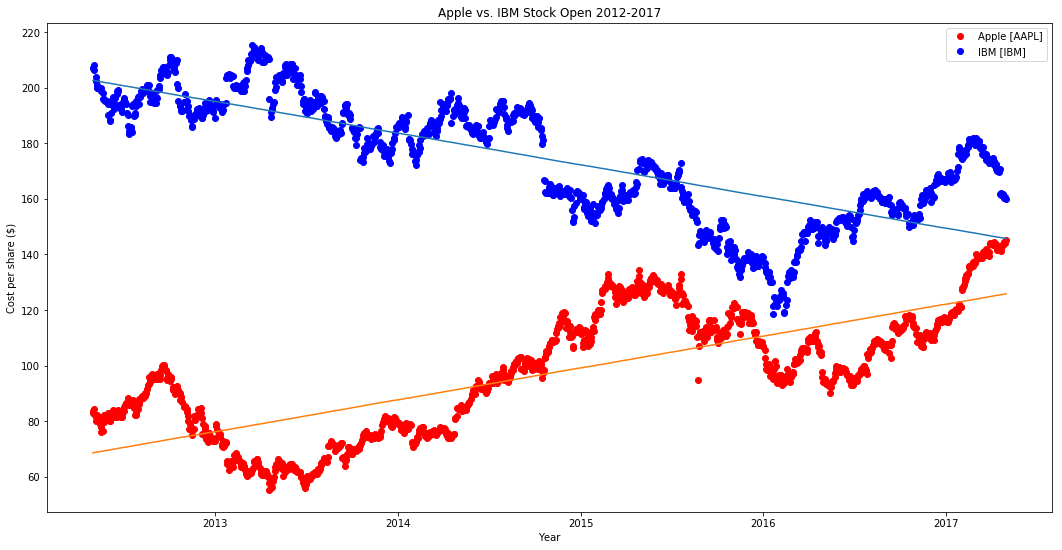

In [7]:
# Set the size of the plot to be created (width x length)
plt.figure(figsize=(18,9))

# We utilize pyplot to graph apple's date as the x-axis vs apple's stock open as the y-axis
# The third argument for the plot, 'ro' indicates the color and symbol of each point
plt.plot(apple['Date'], apple['Open'], 'ro')

plt.plot(ibm['Date'], ibm['Open'], 'bo')

# Here we create a legend for the plot using our custom values and set the location
# to be automatically placed in the 'best' optimal spot
plt.legend(['Apple [AAPL]','IBM [IBM]'],loc="best")

# Plot functions for setting the basic labels: title, x-axis, y-axis
plt.title('Apple vs. IBM Stock Open 2012-2017')
plt.xlabel('Year')
plt.ylabel('Cost per share ($)')

# Calculate the coefficients
coef = np.polyfit(range(1258), ibm['Open'], 1)
coef2 = np.polyfit(range(1258), apple['Open'], 1)

# Calculate the polynomial
pol = np.poly1d(coef)
ys = pol(range(1258))    
pol2 = np.poly1d(coef2)
ys2 = pol2(range(1258))  

# Plot the regression lines on the graph
plt.plot(ibm['Date'],ys)
plt.plot(apple['Date'],ys2)

# Display the plot
plt.show()

Notice how despite the amount of rows and columns being about 6x as big as our previous dataset, all the graphing and regression methods are executed extremely quickly due to pandas' efficiency! Pandas' ability to handle large amounts of data is a key reason why it is utilized so heavily in the field of data science. 

Looking at that graph it almost seems as if Apple's stock performance is inversely correlated with IBM's stock performance, meaning as one stock increases, the other's goes down. We can't tell for sure just yet if this apparent trend is just coincidental or if there happen to be any sort of statistical corroboration. With that said, we can segway into some basic hypothesis testing to affirm whether or not there is a relationship between these stocks.

# Hypothesis Testing
***
Hypothesis testing is an act in statistics whereby an individual tests an assumption they come up with regarding a population parameter. In this case, what we want to test is whether or not there is a correlation between Apple and IBM's stock prices. The process to hypothesis testing is as follows:
>1 - Come up with a null hypothesis

* Null Hypothesis: A null hypothesis is the hypothesis that there is no significant difference between two specified populations

The null hypothesis for our scenario would be the assumption that there is 0 correlation between Apple and IBM's stock prices over the 5 year span.
>2 - Set your significance level

* Significance Level: α(alpha) is called the significance level, and it is the probability of rejecting the null hypothesis given that it is true

Generally the significance level is set at 5%, 1%, or 0.5% if you want to be really certain.
>3 - Compute the probability

* P-Value: The p-value or probability value is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or more extreme than the actual observed results.

When you perform a hypothesis test in statistics, a p-value helps you determine the significance of your results and if the value is less than the significance level that you set, you can reject the null hypothesis.
>4 - Decide whether to reject or accept the null hypothesis

Finally, when the tests have been conducted and you have your results, you have to make a decision of whether to accept or reject the null hypothesis. Usually this is fairly simple since if you set your significance level at 5% (0.05) and you get a p-value of 0.01, clearly it is below the threshold and you can safely reject the null hypothesis. However, there are a couple errors to be aware of in hypothesis testing:
* Type I Error: You accept the null hypothesis when it is in fact incorrect
* Type II Error: You reject the null hypothesis when it is in face correct


Now that this quick hypothesis testing lesson is over, we can get to the actual code for performing the test on the data. The 'scipy' library has a very hefty and extensive statistics support. We can perform a [Pearson correlation test](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) using just one line of code:

In [8]:
cor,p = stats.pearsonr(apple['Open'],ibm['Open'])
print("Correlation between Apple and IBM: " + str(cor) + "\nP-Value: " + str(p))

Correlation between Apple and IBM: -0.605194980681
P-Value: 1.47786949443e-126


Looking at the above results, we can see that there is a correlation of -0.605 which is quite a high value showing that as Apple's stock value goes up, IBM's stock value goes down. The Pearson test has a value range of -1 to +1. The resultant p-value from this test is 1.478e-126 which is extremely low, nearing 0 which means we can very certainly reject the null hypothesis that there is no correlation between Apple and IBM's stock.

# Machine Learning
***
Below you will find code for a basic gradient descent algorithm as well as code for generating a random dataset for usage with the machine learning algorithm's prediction.

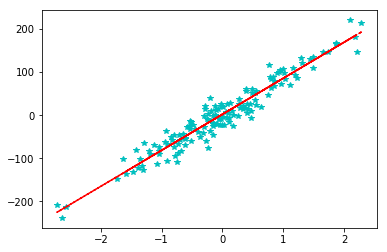

In [9]:
# Gradient descent algorithm
def grad_descent(X, y, T, alpha):
    m, n = X.shape # m = #examples, n = #features
    theta = np.zeros(n) # initialize parameters
    f = np.zeros(T) # track loss over time
    for i in range(T):
        # loss for current parameter vector theta
        f[i] = 0.5*np.linalg.norm(X.dot(theta) - y)**2
        # compute steepest ascent at f(theta)
        g = X.T.dot(X.dot(theta) - y)
        # step down the gradient
        theta = theta - alpha*g
    return theta, f

# Generate random dataset
x, y = datasets.make_regression(n_samples=150, n_features=1, noise=21) 

# Get shape using numpy
m, n = np.shape(x)

x = np.c_[ np.ones(m), x] 
temp = x.shape[1]

theta,f = grad_descent(x, y, 1000, 0.01)
for i in range(temp):
    # Calculate the prediction
    yp = theta[0] + theta[1]*x 

# Plot data points
plt.plot(x[:,1],y,'c*')

# Plot prediction line
plt.plot(x,yp,'r--')

plt.show()

For more resources on implementing your own linear regression algorithm and a more in-depth look at gradient descent, look here: 
* http://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/ 
* http://www.pyimagesearch.com/2016/10/10/gradient-descent-with-python/